# Driver Drowsiness Classification
The goal of this notebook is to perform classification on my created features using Support Vector Machines. 
And to experiment with the segment length untill classification cannot be performed correctly anymore.

In [101]:
import seaborn as sns
from sklearn.svm import SVC
from helping_functions import *
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [102]:
def get_data(subject, treshhold, segment_length):
    status_rates_sleepy, wrong_frames_sleepy = load_blinks(subject, 'sleepy') 
    #print("Sleepy number of frames: ", len(status_rates_sleepy))
    #print("Sleepy missed faces: ", len(wrong_frames_sleepy))
    status_rates_normal, wrong_frames_normal = load_blinks(subject, 'normal') 
    #print("Normal number of frames: ", len(status_rates_normal))
    #print("Normal missed faces: ", len(wrong_frames_normal))
    
    print("Starting segmenting normal condition")
    blink_counts_normal, average_durs_normal = run_analysis(status_rates_normal, wrong_frames_normal, treshhold, segment_length)

    print("Starting segmenting sleepy condition")
    blink_counts_sleepy, average_durs_sleepy = run_analysis(status_rates_sleepy, wrong_frames_sleepy, treshhold, segment_length)
    
    return list(zip(blink_counts_normal, average_durs_normal)), list(zip(blink_counts_sleepy, average_durs_sleepy))

In [103]:
def train_model(X_normal, X_sleepy):
    y_normal = list(np.zeros(len(X_normal)))
    y_sleepy = list(np.ones(len(X_sleepy)))

    X = X_normal + X_sleepy
    y = y_normal + y_sleepy

    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    #print("Maximum values :", scaler.data_max_)
    #print("Minimum values :", scaler.data_min_)

    X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3,random_state=41)
    
    # train model
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_round =  round(f1, 2) 
    print("F1 score: ", f1_round)


    return model, f1_round, X_train, X_test, y_train, y_test

## Training models for multiple segment lengths

In [45]:
def multi_seg_lens(subject, treshhold, min_list):
    models = []
    f1_scores = []
    for minutes in min_list:
        print("Segment length: " + str(minutes))
        segment_length = int(2760 * minutes)
        X_normal, X_sleepy = get_data(subject, treshhold, segment_length)
        model, f1_round, X_train, X_test, y_train, y_test = train_model(X_normal, X_sleepy)
        f1_scores.append(f1_round)
        models.append(model)
    return models, f1_scores

subject = 'subject16'
treshhold = 10
min_list = [0.2,1,2,5,8]

models, f1_scores = multi_seg_lens(subject, treshhold, min_list)
print(f1_scores)

Segment length: 0.2
Starting segmenting normal condition



KeyboardInterrupt



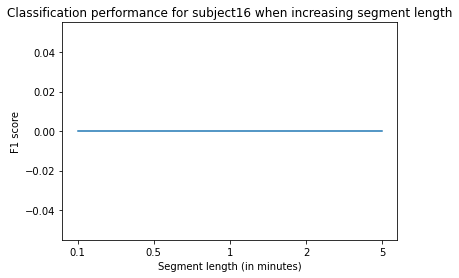

In [44]:
def plot_multi_seg(subject, min_list, f1_scores):
    x_values = range(len(min_list))
    plt.plot(x_values, f1_scores)
    plt.xticks(x_values, min_list)
    plt.xlabel('Segment length (in minutes)')
    plt.ylabel('F1 score')
    plt.title('Classification performance for '+ subject + ' when increasing segment length')
    plt.show()
    
plot_multi_seg(subject, min_list, f1_scores)

## Multiple subjects classification (subject-individually)

In [90]:
def multi_subjects(subjects, threshold, min_list):
    sum_f1_scores = np.zeros(len(min_list))
    all_f1_scores = []
    for sub in subjects:
        subject = 'subject' + str(sub)
        f1_scores = multi_seg_lens(subject, threshold, min_list)[1]
        all_f1_scores.append(f1_scores)
        sum_f1_scores = sum_f1_scores + np.array(f1_scores)
        print("SUBJECT" + str(sub)+ " DONE", f1_scores)
    avg_f1_scores = sum_f1_scores / len(subjects)

    x_values = range(len(min_list))
    plt.plot(x_values, list(avg_f1_scores))
    plt.xticks(x_values, min_list)
    plt.xlabel('Segment length (in minutes)')
    plt.ylabel('F1 score')
    plt.title('Classification performance for all subjects when increasing segment length')
    plt.savefig('../final_figures/class_f1_analysis_poly.jpg')
    plt.show()
    return all_f1_scores, avg_f1_scores

Segment length: 0.1
Starting segmenting normal condition
Number of segments 589
Starting segmenting sleepy condition
Number of segments 542
F1 score:  0.69
Segment length: 0.5
Starting segmenting normal condition
Number of segments 117
Starting segmenting sleepy condition
Number of segments 107
F1 score:  0.8
Segment length: 1
Starting segmenting normal condition
Number of segments 58
Starting segmenting sleepy condition
Number of segments 53
F1 score:  0.8
Segment length: 2
Starting segmenting normal condition
Number of segments 28
Starting segmenting sleepy condition
Number of segments 26
F1 score:  0.75
Segment length: 5
Starting segmenting normal condition
Number of segments 10
Starting segmenting sleepy condition
Number of segments 9
F1 score:  1.0
SUBJECT1 DONE [0.69, 0.8, 0.8, 0.75, 1.0]
Segment length: 0.1
Starting segmenting normal condition
Number of segments 549
Starting segmenting sleepy condition
Number of segments 285
F1 score:  0.49
Segment length: 0.5
Starting segmentin

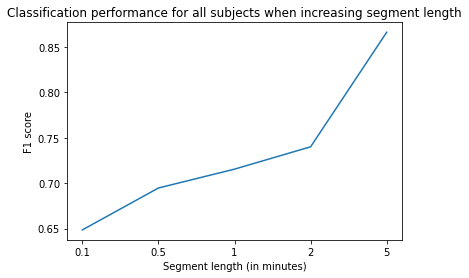

In [91]:
subjects = [1,3,4,6,7,9,10,12,14,15,22,23,24]
threshold = 10
min_list = [0.1,0.5,1,2,5]
scores, avg_scores = multi_subjects(subjects, threshold, min_list)

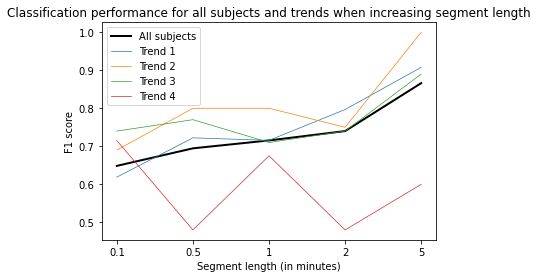

In [100]:
# because of too little semgments, subjects 11,16, 20 and 25 are removed
trends = {'1':[3,4,6,9,10,14,15,23,24], '2':[1], '3':[7], '4':[12,22]}
def plot_performance_trends(scores, avg_scores, trends, min_list):
    x_values = range(len(min_list))
    
    # plotting performance for all trends
    plt.plot(x_values, list(avg_scores), label = "All subjects", linewidth = 2, color='black')
    
    # plotting performances across trends individually
    for t in range(1,5):
        idx = [subjects.index(sub) for sub in trends[str(t)]]
        trend_scores = np.array(scores)[idx]
        trend_mean = np.mean(trend_scores, axis=0)
        plt.plot(x_values, list(trend_mean), label = 'Trend ' + str(t), linewidth=0.7)
    

    plt.xticks(x_values, min_list)
    plt.xlabel('Segment length (in minutes)')
    plt.ylabel('F1 score')
    plt.legend()
    plt.title('Classification performance for all subjects and trends when increasing segment length')
    plt.savefig('../final_figures/class_f1_analysis_trends.jpg')
    plt.show()
    
plot_performance_trends(scores, avg_scores, trends, min_list)

## Training 1 model

In [244]:
# Choose which subject
subject = 'subject1'

# Parameters
treshhold = 10
minutes = 1
segment_length = int(2760) * minutes


X_normal, X_sleepy = get_data(subject, treshhold, segment_length)

STARTING SEGMENTING NORMAL CONDITION
Number of blinks:  3731
0
30000
60000
90000
120000
150000
Number of segments 58
Mean blink count per segment 63.36206896551724
Mean blink duration per segment 3.554221180109667
STARTING SEGMENTING SLEEPY CONDITION
Number of blinks:  2545
0
30000
60000
90000
120000
Number of segments 53
Mean blink count per segment 46.58490566037736
Mean blink duration per segment 5.9381806401380155


In [240]:
model, f1_round, X_train, X_test, y_train, y_test = train_model(X_normal, X_sleepy)

F1 score:  0.8
SVC(kernel='linear')
0.8


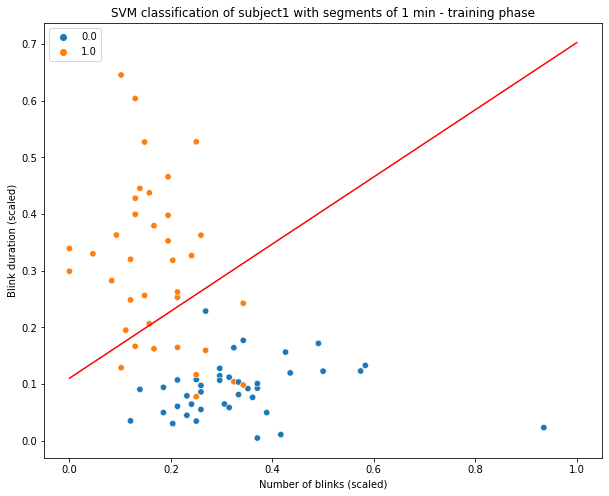

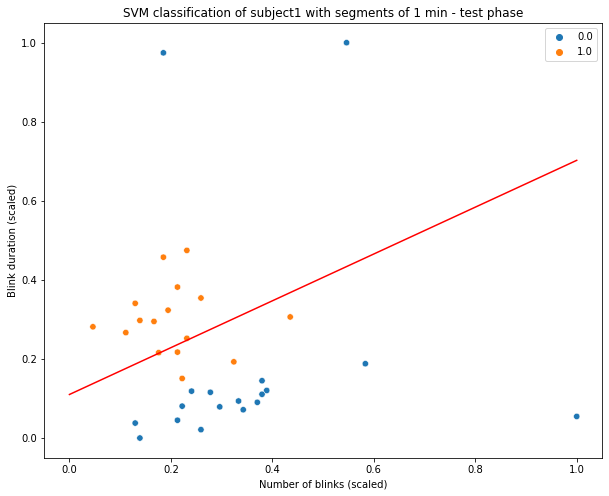

In [241]:
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=X_train[:, 0], 
                y=X_train[:, 1], 
                hue=y_train, 
                s=40);

w = model.coef_[0]
b = model.intercept_[0]
x_points = np.linspace(0, 1)
y_points = -(w[0] / w[1]) * x_points - b / w[1]

# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');
plt.xlabel('Number of blinks (scaled)')
plt.ylabel('Blink duration (scaled)')
plt.title('SVM classification of ' + subject + ' with segments of ' + str(minutes) + ' min - training phase')
#plt.savefig('../figures/svm_' + subject + '_min' + str(minutes) + '-training.jpg')
plt.show()


# Testing phase
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=X_test[:, 0], 
                y=X_test[:, 1], 
                hue=y_test, 
                s=40);

w = model.coef_[0]
b = model.intercept_[0]
x_points = np.linspace(0, 1)
y_points = -(w[0] / w[1]) * x_points - b / w[1]

# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');

# Plotting textbox with F1 score
props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
#plt.text(0.05, 1, "F1 score : " + str(f1_round), fontsize=12,
        #verticalalignment='top', bbox=props)

plt.xlabel('Number of blinks (scaled)')
plt.ylabel('Blink duration (scaled)')
plt.title('SVM classification of ' + subject + ' with segments of ' + str(minutes) + ' min - test phase')
#plt.savefig('../figures/svm_' + subject + '_min' + str(minutes) + '-test.jpg')
plt.show()

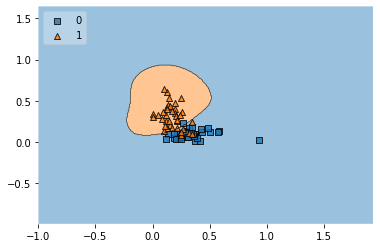

F1 score rbf:  0.9


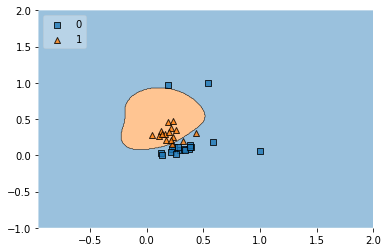

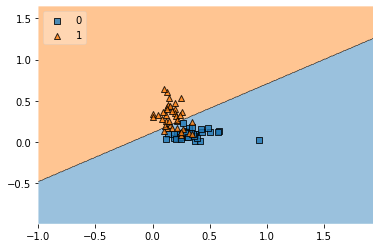

F1 score lin:  0.8


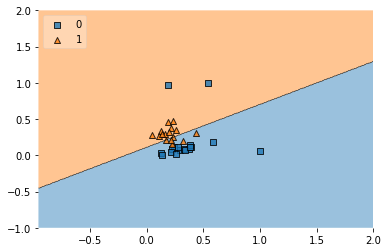

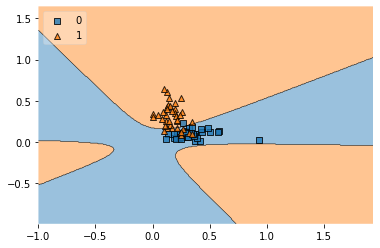

F1 score poly:  0.88


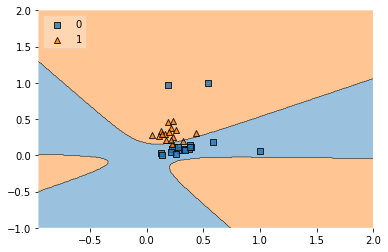

In [237]:
from mlxtend.plotting import plot_decision_regions

model_rbf =  SVC(kernel='rbf')
model_rbf.fit(X_train, y_train)
plot_decision_regions(X_train, np.array(y_train).astype(np.int_), clf=model_rbf, legend=2)
plt.show()

y_pred = model_rbf.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1_round =  round(f1, 2) 
print("F1 score rbf: ", f1_round)
plot_decision_regions(X_test, np.array(y_test).astype(np.int_), clf=model_rbf, legend=2)
plt.show()

model_lin =  SVC(kernel='linear')
model_lin.fit(X_train, y_train)
plot_decision_regions(X_train, np.array(y_train).astype(np.int_), clf=model_lin, legend=2)
plt.show()

y_pred = model_lin.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1_round =  round(f1, 2) 
print("F1 score lin: ", f1_round)
plot_decision_regions(X_test, np.array(y_test).astype(np.int_), clf=model_lin, legend=2)
plt.show()

model_poly =  SVC(kernel='poly')
model_poly.fit(X_train, y_train)
plot_decision_regions(X_train, np.array(y_train).astype(np.int_), clf=model_poly, legend=2)
plt.show()

y_pred = model_poly.predict(X_test)
f1 = f1_score(y_test, y_pred)
f1_round =  round(f1, 2) 
print("F1 score poly: ", f1_round)
plot_decision_regions(X_test, np.array(y_test).astype(np.int_), clf=model_poly, legend=2)
plt.show()

# General classification (all subjects with 1 model)

In [114]:
# !!!!!! This is wrong, I have to exclude some subjects for testing!! !!!!!
def get_gen_class_data(subjects, threshold, segment_length):
    first = True
    for sub in subjects:
        subject = 'subject' + str(sub)
        if first:
            X_normal, X_sleepy = get_data(subject, treshhold, segment_length)
            X_normal = np.array(X_normal)
            X_sleepy = np.array(X_sleepy)
            first = False
        else:
            new_X_normal, new_X_sleepy = get_data(subject, treshhold, segment_length)
            X_normal = np.concatenate((X_normal, np.array(new_X_normal)), axis=0)
            X_sleepy = np.concatenate((X_sleepy, np.array(new_X_sleepy)), axis=0)
            
    return X_normal.tolist(), X_sleepy.tolist()

subjects = [1,3,4,6,7,9,10,12,14,15,22,23,24]
threshold = 10
seg_len = 2760

X_normal, X_sleepy = get_gen_class_data([1,3], threshold, seg_len)

model, f1_round, X_train, X_test, y_train, y_test =  train_model(X_normal, X_sleepy)

Starting segmenting normal condition
Number of segments 58
Starting segmenting sleepy condition
Number of segments 53
Starting segmenting normal condition
Number of segments 54
Starting segmenting sleepy condition
Number of segments 27
F1 score:  0.37
